In [ ]:
!pip install albumentations==1.1.0 --quiet
!pip install pytorch_lightning --quiet

     |████████████████████████████████| 102 kB 5.7 MB/s 
     |████████████████████████████████| 37.1 MB 92 kB/s 
     |████████████████████████████████| 925 kB 4.0 MB/s 
     |████████████████████████████████| 829 kB 39.6 MB/s 
     |████████████████████████████████| 596 kB 53.4 MB/s 
     |████████████████████████████████| 282 kB 56.7 MB/s 
     |████████████████████████████████| 125 kB 69.0 MB/s 
     |████████████████████████████████| 1.3 MB 52.0 MB/s 
     |████████████████████████████████| 271 kB 53.1 MB/s 
     |████████████████████████████████| 160 kB 45.7 MB/s 


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from collections import defaultdict
import copy
import pytorch_lightning as pl
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import cv2
from xml.etree import ElementTree as et
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from tqdm.notebook import tqdm, trange
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:0


In [ ]:
classes = [_,'with_mask','without_mask']
# classes.append('mask_weared_incorrect')
num_classes = len(classes)

In [ ]:
class MaskDataset(torch.utils.data.Dataset):
    def __init__(self,root, width = 640, height = 640, transforms = None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.annots = list(sorted(os.listdir(os.path.join(root, "annotations"))))
        self.classes = [_,'with_mask','without_mask']
        self.width,self.height = width,height
#         for future
        # self.classes.append('mask_weared_incorrect')
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "annotations", self.annots[idx])
        img = Image.open(img_path).convert("RGB")
#         img = cv2.imread(img_path)
        wt, ht = img.size
#         print(wt,ht,img_path)
#         img = np.asarray(img)
        boxes = []
        labels = []
        tree = et.parse(annot_path)
        root = tree.getroot()
        for member in root.findall('object'):
            label = member.find('name').text
            if label == "mask_weared_incorrect":
              label = "without_mask"
            labels.append(self.classes.index(label))
            
            # bounding box
            xmin = min(wt,int(member.find('bndbox').find('xmin').text))
            xmax = min(wt,int(member.find('bndbox').find('xmax').text))
            
            ymin = min(ht,int(member.find('bndbox').find('ymin').text))
            ymax = min(ht,int(member.find('bndbox').find('ymax').text))
            
#             xmin_corr = (xmin/wt)*self.width
#             xmax_corr = (xmax/wt)*self.width
#             ymin_corr = (ymin/ht)*self.height
#             ymax_corr = (ymax/ht)*self.height
            
#             boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
            boxes.append([xmin, ymin, xmax, ymax])
#             print([xmin, ymin, xmax, ymax])
            assert(xmin <= wt)
            assert(xmax <= wt)
            assert(ymin <= ht)
            assert(ymax <= ht)
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
#         print(type(img))
        # print(img_path,xmin,xmax,ymin,ymax)
        if self.transforms is not None:
            image_np = np.array(img)
#             print(type(image_np),self.transforms(image = image_np,bboxes = target['boxes'],labels = labels))
            sample = self.transforms(image = image_np,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
#             print(target['boxes'])
#             print(type(sample['image']),img.shape)
        return (img, target)
    def __len__(self):
        return len(self.imgs)

In [ ]:
len(MaskDataset(root = ".",width=640,height = 640))

853

In [ ]:
def get_transform(train):
    transforms = None
    if train:
        transforms = A.Compose([
            A.augmentations.geometric.resize.Resize(640,640),
            # A.augmentations.transforms.HorizontalFlip(),
            A.Normalize(),
            ToTensorV2()
        ],bbox_params=A.BboxParams(format='pascal_voc',label_fields = ['labels']))
    return transforms

# Faster-RCNN Model

In [ ]:
dataset = MaskDataset('.', width =640,height = 640,transforms = get_transform(train = True))
len_dataset = len(dataset)
trainset,testset = torch.utils.data.random_split(dataset, [round(0.8*len_dataset),round(0.2*len_dataset)], generator=torch.Generator().manual_seed(42))

In [ ]:
print(len(trainset)+len(testset))
print(len(trainset))
print(len(testset))

853
682
171


In [ ]:
batch_size = 16

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))
trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True,
        collate_fn=collate_fn)
testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False,
        collate_fn=collate_fn)

In [ ]:
class FasterRCNN(pl.LightningModule):

    def __init__(self,learning_rate=0.001, model = None):
        super().__init__()
        self.model = model
        self.lr = self.learning_rate = learning_rate

    def forward(self, x, *args, **kwargs):
        return self.model(x)
    def configure_optimizers(self):
        params = [p for p in model.parameters() if p.requires_grad]
        # optimizer = torch.optim.Adam(params,lr = (self.learning_rate or self.lr))
        optimizer = torch.optim.SGD(params, lr = 0.001, momentum = 0.9, weight_decay = 0.0001)
        return optimizer
    
    def train_dataloader(self):
#       global var trainloader
        train_loader = trainloader
        return train_loader

    def val_dataloader(self):
        valid_loader = testloader
        return valid_loader

    def training_step(self, batch, batch_idx):
        images, targets = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        # separate losses
        loss_dict = self.model(images, targets)
        # total loss
        losses = sum(loss for loss in loss_dict.values())

        return {'loss': losses, 'log': loss_dict, 'progress_bar': loss_dict}

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)    
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes = num_classes)
model = FasterRCNN(model = model)

In [ ]:
trainer = pl.Trainer(gpus=1,max_epochs=40)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.3 M
-------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.217   Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

In [ ]:
#!rm -rf annotations

In [ ]:
torch.save(model.state_dict(),"faster_rcnn.pth")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model.load_state_dict(torch.load("faster_rcnn.pth"))

<All keys matched successfully>

# Mean-Average-Precision(mAP) at threshold 0.5 for IOU

In [ ]:
def intersection_over_union(boxes_preds, boxes_labels):
    """
    Credits: Aladdin Person
    """
    box1_x1 = boxes_preds[..., 0:1]
    box1_y1 = boxes_preds[..., 1:2]
    box1_x2 = boxes_preds[..., 2:3]
    box1_y2 = boxes_preds[..., 3:4]
    box2_x1 = boxes_labels[..., 0:1]
    box2_y1 = boxes_labels[..., 1:2]
    box2_x2 = boxes_labels[..., 2:3]
    box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Need clamp(0) in case they do not intersect, then we want intersection to be 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [ ]:
from collections import Counter

def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, num_classes=20
):
    """
    Credits: Aladdin Person
    """
    average_precisions = []
    epsilon = 1e-6
    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [ ]:
def populate_gt_boxes(dataloader):
    gt_boxes = torch.empty(0,6)
    print(gt_boxes.shape)
    for i,data in enumerate(dataloader):
        images,targets = data
        for target in targets:
            # temp = torch.empty(0,7)
            for idx,box in enumerate(target['boxes']):
                temp = torch.tensor([target['image_id'].item(),target['labels'][idx].item()])
                temp = torch.cat((temp,box))
                temp = torch.unsqueeze(temp,0)
                gt_boxes = torch.cat((gt_boxes,temp),axis = 0)
            # print(target)
            # print(gt_boxes)
            # return
        del images, targets
        torch.cuda.empty_cache()
    return gt_boxes
gt_boxes = populate_gt_boxes(testloader)

torch.Size([0, 6])


In [ ]:
def populate_pred_boxes(model, dataloader):
  model.eval()
  model = model.to('cpu')
  predicted_boxes = torch.empty(0,7)
  for i,data in enumerate(dataloader):
    images,targets = data
    targets_ids = [target['image_id'].item() for target in targets]
    preds = model(images)
    for i,pred in enumerate(zip(targets_ids,preds)):
      image_id,pred_boxes = pred
      for idx,box in enumerate(pred_boxes['boxes']):
        temp = torch.tensor([image_id,pred_boxes['labels'][idx].item(),pred_boxes['scores'][idx].item()])
        temp = torch.cat((temp,box))
        temp = torch.unsqueeze(temp,0)
        predicted_boxes = torch.cat((predicted_boxes,temp), axis = 0)
    del images,targets
    torch.cuda.empty_cache()
  return pred_boxes
pred_boxes = populate_pred_boxes(model,testloader)

In [ ]:
mean_average_precision(pred_boxes,gt_boxes, num_classes = num_classes)

RuntimeError: ignored

#SAMPLE TESTING


In [ ]:
class SampleMaskDataset(torch.utils.data.Dataset):
    def __init__(self,root, width = 640, height = 640, transforms = None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "sampleimages"))))
   
        self.classes = [_,'with_mask','without_mask']
        self.width,self.height = width,height
#         for future
        # self.classes.append('mask_weared_incorrect')
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "sampleimages", self.imgs[idx])
        
        print(img_path)
        img = Image.open(img_path).convert("RGB")
#         img = cv2.imread(img_path)
        wt, ht = img.size
#         print(wt,ht,img_path)
#         img = np.asarray(img)
        boxes = []
        labels = []
        
        image_id= torch.tensor([idx])
      

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        
#         print(type(img))
#         print(idx)
        if self.transforms is not None:
            image_np = np.array(img)
#             print(type(image_np),self.transforms(image = image_np,bboxes = target['boxes'],labels = labels))
            sample = self.transforms(image = image_np,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
#             print(target['boxes'])
#             print(type(sample['image']),img.shape)
        return (img, target)
    def __len__(self):
        return len(self.imgs)

In [ ]:
sampledataset= SampleMaskDataset('.', width =640,height = 640,transforms = get_transform(train = True))
sampleloader= torch.utils.data.DataLoader(
        sampledataset, batch_size=4, shuffle=False,
        collate_fn=collate_fn)


./sampleimages/1.jpg
./sampleimages/3.jpg
./sampleimages/4.jpg
./sampleimages/download.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


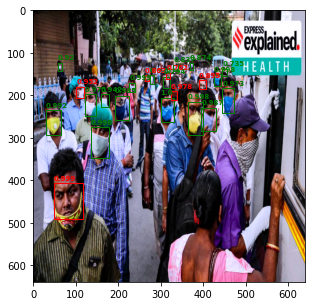

In [ ]:
%matplotlib inline
def plot_img_bbox(dataloader):
    dataiter = iter(dataloader)
    images,targets = next(dataiter)
    #images,targets = next(dataiter)
    # print(targets[0]['image_id'])
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    img = torch.unsqueeze(images[3],0)
    
    # print(img.shape)
    # print(img_np)
    model.eval()
    pred = model(img)
    nms_prediction = apply_nms(pred[0], iou_thresh=0.2)
    pred=[nms_prediction]
    # print(nms_prediction)
    
    inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
    )
    inv_tensor = inv_normalize(img)
    # print(inv_tensor.shape,inv_tensor,img)
    img_np = inv_tensor[0].numpy()
    #[c,h,w]--> h,w,c
    img_np = img_np.transpose(1,2,0)
    #img_np = img_np.astype('uint8')
    a.imshow(img_np)
    # print(pred)
    if (len(pred[0]["boxes"])==0):
      return
    scores1= (str(round(float(pred[0]['scores'][0].item()),3)))
    
    # print (type(scores1))
    
    for i,box in enumerate(pred[0]['boxes']):
        scores1= (str(round(float(pred[0]['scores'][i].item()),3)))
        if float(scores1)<0.6:
          continue

        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        if (pred[0]['labels'][i]==1):
          rect = patches.Rectangle((x, y),
                                  width, height,
                                  linewidth = 1,
                                  edgecolor = 'g',
                                  facecolor = 'none')
          a.add_patch(rect)
          a.text(x,(y-20),str(scores1),verticalalignment='top',
          color='green',fontsize=7,weight='bold')
          
          

        if (pred[0]['labels'][i]==2):
          rect = patches.Rectangle((x, y),
                                  width, height,
                                  linewidth = 1,
                                  edgecolor = 'r',
                                  facecolor = 'none')
          a.add_patch(rect)
          a.text(x,(y-20),str(scores1),verticalalignment='top',
          color='red',fontsize=7,weight='bold')
        
        
        

          


#     plt.show()
    model.train()
plot_img_bbox(sampleloader)


In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.3):

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction